In [62]:
!pip install mlxtend networkx
!pip install wordcloud

In [63]:
# --- Celda de Imports para Modelado ---
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Para Reglas de Asociación
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import networkx as nx

# Para Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Configuraciones de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# --- Cargar los datos preprocesados ---
data_path = Path("data/processed_for_modeling")
#Datos de playlist full
df_playlist = pd.read_parquet(data_path / "df_playlist_full.parquet")


#Datos para Reglas de Asociación
df_transactions = pd.read_parquet(data_path / "transactions_matrix.parquet")

# Datos para Clustering de Playlist
playlist_pca = pd.read_parquet(data_path / "playlist_pca_components.parquet")
playlist_umap = pd.read_parquet(data_path / "playlist_umap_embedding.parquet")

# DataFrame completo para agregación a nivel de playlist
playlist_for_clustering = pd.read_parquet(data_path / "playlist_for_clustering.parquet")

print("Datos cargados exitosamente.")
# print(f"Matriz de transacciones shape: {df_transactions.shape}")
print(f"DataFrame para clustering de playlist shape: {playlist_pca.shape}")

Datos cargados exitosamente.
DataFrame para clustering de playlist shape: (8192, 10)


In [64]:
#trayendo los tracks
df_processed = pd.read_parquet(data_path / "df_processed_full.parquet")
print(f"DataFrame de tracks shape: {df_processed.shape}")

DataFrame de tracks shape: (124096, 65)


In [65]:

columns_to_drop = ["name", "artist_name", "track_name", "duration_ms", "album_name", "track_id"]
playlist_for_clustering = playlist_for_clustering.drop(columns=columns_to_drop)

print(f"DataFrame for playlist clustering after dropping columns: {playlist_for_clustering.shape}")

DataFrame for playlist clustering after dropping columns: (8192, 63)


In [66]:
playlist_for_clustering.head()

,bpm,energy,danceability_ll,loudness,danceability_danceable,gender_female,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,...,mood_relaxed_relaxed,mood_sad_sad,moods_mirex_Cluster1,moods_mirex_Cluster2,moods_mirex_Cluster3,moods_mirex_Cluster4,moods_mirex_Cluster5,timbre_bright,tonal_atonal_atonal,voice_instrumental_voice
pid,,,,,,,,,,,,,,,,,,,,,
1000000,0.160221,0.674865,-0.575001,-0.010197,0.712000,0.890641,-0.498757,-0.430456,0.519981,-0.481145,...,1.130548,0.525529,0.893153,0.420956,-0.730197,1.004184,-0.387829,-1.441935,1.124915,0.680423
1000016,0.163519,-0.810939,-0.626563,0.125442,0.868356,0.476394,-0.066965,-0.304414,0.348512,-0.315390,...,0.761068,0.333386,0.225041,0.561850,-0.327078,0.033352,-0.169638,0.538302,0.921453,0.575065
1000020,-1.077283,-0.688983,0.546987,0.640798,0.783371,-1.097435,0.774962,0.549553,-0.859564,0.816959,...,0.255334,-0.652246,-0.605235,0.161703,-0.469690,2.516636,-0.905760,0.377803,0.092759,0.883734
1000023,0.241503,-0.266371,-0.454821,-0.155309,0.863899,0.889459,-0.545234,-0.502872,0.626467,-0.511086,...,0.814086,-0.971319,0.251995,-0.396421,-0.242822,1.161871,-0.155746,-0.384361,1.143995,0.408990
1000040,0.323022,-0.178108,1.983277,0.820105,0.844329,0.954552,-0.688467,-0.529099,0.678053,-0.525163,...,0.536261,-0.100615,-0.792774,0.123877,0.279067,1.727907,-0.806363,1.160039,1.001671,-0.930150


In [67]:
playlist_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
pid,,,,,,,,,,
1000000,-0.663803,-0.631957,4.806233,2.348698,-1.628967,-0.781611,3.238690,1.171119,-2.040517,2.240854
1000016,-1.349871,0.000669,0.607624,-0.475811,1.879978,2.161518,-2.195647,0.174255,0.376852,0.624177
1000020,0.233109,4.628954,-0.889581,0.257637,-0.817259,0.401576,-0.180352,0.579727,0.363847,0.005663
1000023,-3.502215,0.524163,-0.833910,-0.632196,-1.481683,0.398017,-0.946594,4.065633,-1.825655,-1.087756
1000040,-0.979415,-1.463812,0.872277,0.829315,0.013625,2.956005,-0.203531,-0.288747,-0.247835,0.576816


# 5: Clustering (Agrupación)
Dividiremos esta sección en dos partes, como se discutió: clustering de tracks y de playlists.

**Parte A: Clustering a Nivel de playlist **


## 5.A.1 Algoritmo 1: K-Means con Búsqueda de K Óptimo

Shape original de X_playlist: (8192, 2)
Shape de X_playlist_numeric (solo columnas numéricas): (8192, 2)



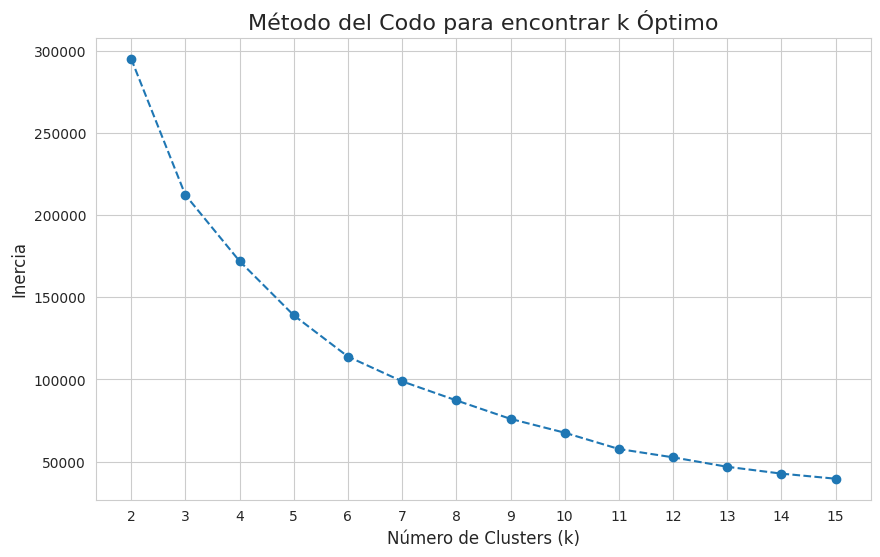

In [68]:
# --- 5.A.1 K-Means (Versión Corregida) ---
# Usamos el método del codo (Elbow Method) para encontrar un buen valor para k

X_playlist = playlist_umap.copy() # Datos de entrada originales

# --- LA CORRECCIÓN ESTÁ AQUÍ ---
# K-Means solo puede trabajar con números. Nos aseguramos de seleccionar solo las columnas numéricas.
# El error 'could not convert string to float: 'Party'' indica que columnas de texto se colaron.
X_playlist_numeric = X_playlist.select_dtypes(include=np.number)

print(f"Shape original de X_playlist: {X_playlist.shape}")
print(f"Shape de X_playlist_numeric (solo columnas numéricas): {X_playlist_numeric.shape}\n")


# --- Continuación del código original, usando el DataFrame NUMÉRICO ---
inertia = []
K_range = range(2, 16) # Probaremos con k de 2 a 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Usamos el DataFrame NUMÉRICO para el ajuste
    kmeans.fit(X_playlist_numeric)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para encontrar k Óptimo')
plt.xticks(K_range)
plt.show()



## 5.A.2 Algoritmos 2 y 3: DBSCAN y Agglomerative Clustering (reemplazado x MiniBatchKMeans)


In [69]:
# Basado en el gráfico, elegimos un valor para k (ej. k=9 donde la curva se aplana)
OPTIMAL_K = 10
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
# Usamos el DataFrame NUMÉRICO aquí también
playlist_labels_kmeans = kmeans.fit_predict(X_playlist_numeric)

print(f"\nClustering con K-Means completado usando k={OPTIMAL_K}.")
# --- 5.A.2 Algoritmos 2 y 3: DBSCAN y MiniBatchKMeans (CORREGIDO Y OPTIMIZADO) ---

# --- DBSCAN ---
# DBSCAN puede ser lento en datasets grandes. Sus hiperparámetros son clave.
# Si esta parte también es muy lenta, considera ejecutarla sobre una muestra o ajustar 'eps'.
print("Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=2.5, min_samples=20, n_jobs=-1) # n_jobs=-1 usa todos los núcleos de tu CPU
playlist_labels_dbscan = dbscan.fit_predict(X_playlist_numeric)
print("DBSCAN completado.")


# --- MiniBatchKMeans (Reemplazo eficiente para Agglomerative Clustering) ---
# Este algoritmo es mucho más rápido y consume muchísima menos memoria.
print("Ejecutando MiniBatchKMeans...")
mini_batch_kmeans = MiniBatchKMeans(
    n_clusters=OPTIMAL_K, # Usamos el mismo k que en KMeans
    random_state=42,
    batch_size=256, # Tamaño del lote, un hiperparámetro a ajustar
    n_init=10
)
playlist_labels_minibatch = mini_batch_kmeans.fit_predict(X_playlist_numeric)
print("MiniBatchKMeans completado.")



Clustering con K-Means completado usando k=10.
Ejecutando DBSCAN...
DBSCAN completado.
Ejecutando MiniBatchKMeans...
MiniBatchKMeans completado.


# --- 5.A.3 Evaluación Comparativa y Visualización

In [70]:



# --- 5.A.3 Evaluación Comparativa y Visualización (CORREGIDO) ---
print("\nCalculando métricas de evaluación...")

# K-Means
score_s_kmeans = silhouette_score(X_playlist_numeric, playlist_labels_kmeans)
score_db_kmeans = davies_bouldin_score(X_playlist_numeric, playlist_labels_kmeans)

# DBSCAN (excluyendo ruido)
print("Evaluando DBSCAN...")
mask_dbscan = playlist_labels_dbscan != -1 # Filtro para excluir puntos de ruido (label -1)

# Nos aseguramos de que DBSCAN haya encontrado más de 1 clúster para poder evaluar
if len(set(playlist_labels_dbscan[mask_dbscan])) > 1:
    # Usamos una muestra para que el cálculo del score sea rápido en datasets grandes
    # Tomamos una muestra de hasta 20,000 points that are not noise
    sample_size = min(20000, np.sum(mask_dbscan))

    # --- FIX START ---
    # Reset the index of X_playlist_numeric to allow for integer indexing
    X_playlist_numeric_reset = X_playlist_numeric.reset_index(drop=True)
    # Use the index of the filtered data (mask_dbscan) to sample
    sample_indices = np.random.choice(X_playlist_numeric_reset[mask_dbscan].index, size=sample_size, replace=False)

    score_s_dbscan = silhouette_score(X_playlist_numeric_reset.loc[sample_indices], playlist_labels_dbscan[sample_indices])
    score_db_dbscan = davies_bouldin_score(X_playlist_numeric_reset.loc[sample_indices], playlist_labels_dbscan[sample_indices])
    # --- FIX END ---
else:
    # If DBSCAN did not find clusters (or only one), assign an invalid score
    print("DBSCAN no encontró suficientes clusters para ser evaluado.")
    score_s_dbscan = -1
    score_db_dbscan = -1

# MiniBatchKMeans
print("Evaluando MiniBatchKMeans...")
score_s_minibatch = silhouette_score(X_playlist_numeric, playlist_labels_minibatch)
score_db_minibatch = davies_bouldin_score(X_playlist_numeric, playlist_labels_minibatch)


# Crear tabla de resultados
# CORREGIDO: Actualizamos la lista de algoritmos y las variables de los scores.
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'MiniBatchKMeans'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_minibatch],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_minibatch]
})

print("\n--- Tabla Comparativa de Modelos de Clustering de playlist ---")
display(results)

# (El código de visualización que ya tenías funcionará igual)
# ...


Calculando métricas de evaluación...
Evaluando DBSCAN...
Evaluando MiniBatchKMeans...

--- Tabla Comparativa de Modelos de Clustering de playlist ---


,Algoritmo,Silhouette Score (más alto es mejor),Davies-Bouldin Score (más bajo es mejor)
0,K-Means,0.411077,0.717788
1,DBSCAN,0.358953,0.340665
2,MiniBatchKMeans,0.407657,0.850427


# 5.A.3 Evaluación Comparativa y Visualización



Calculando métricas de evaluación...
Evaluando K-Means...
Evaluando DBSCAN...
Evaluando MiniBatchKMeans...

--- Tabla Comparativa de Modelos de Clustering de playlist ---


,Algoritmo,Silhouette Score (más alto es mejor),Davies-Bouldin Score (más bajo es mejor)
0,K-Means,0.411077,0.717788
1,DBSCAN,0.358953,0.340665
2,MiniBatchKMeans,0.407657,0.850427



Generando visualización de clusters (ejemplo con K-Means)...


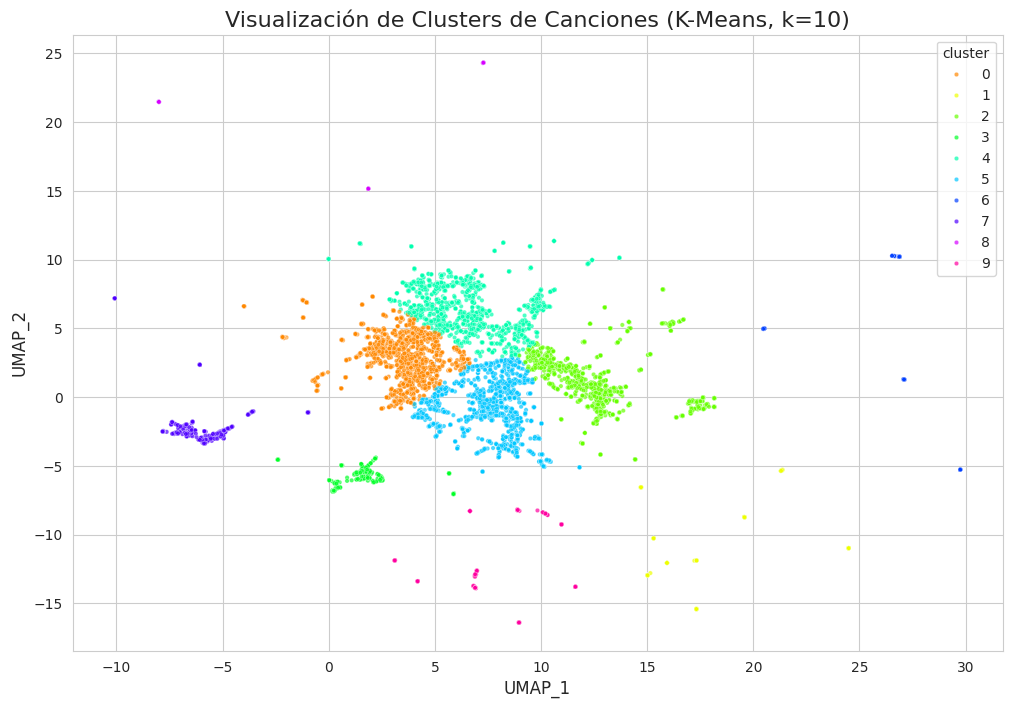

In [71]:
# --- 5.A.3 Evaluación Comparativa y Visualización (MODIFICADO Y CORREGIDO) ---

print("\nCalculando métricas de evaluación...")

# --- K-Means ---
# CORREGIDO: Usamos X_playlist_numeric para el cálculo de los scores.
print("Evaluando K-Means...")
score_s_kmeans = silhouette_score(X_playlist_numeric, playlist_labels_kmeans)
score_db_kmeans = davies_bouldin_score(X_playlist_numeric, playlist_labels_kmeans)

# --- DBSCAN ---
# CORREGIDO: Usamos X_playlist_numeric y mantenemos la optimización de muestreo para el cálculo.
print("Evaluando DBSCAN...")
mask_dbscan = playlist_labels_dbscan != -1 # Filtro para excluir puntos de ruido (label -1)

# Nos aseguramos de que DBSCAN haya encontrado más de 1 clúster para poder evaluar
if len(set(playlist_labels_dbscan[mask_dbscan])) > 1:
    # Usamos una muestra para que el cálculo del score sea rápido en datasets grandes
    # Tomamos una muestra de hasta 20,000 puntos que no sean ruido
    sample_size = min(20000, np.sum(mask_dbscan))

    # --- FIX START ---
    # Reset the index of X_playlist_numeric to allow for integer indexing
    X_playlist_numeric_reset = X_playlist_numeric.reset_index(drop=True)
    # Use the index of the filtered data (mask_dbscan) to sample from the reset DataFrame
    sample_indices = np.random.choice(X_playlist_numeric_reset[mask_dbscan].index, size=sample_size, replace=False)

    score_s_dbscan = silhouette_score(X_playlist_numeric_reset.loc[sample_indices], playlist_labels_dbscan[sample_indices])
    score_db_dbscan = davies_bouldin_score(X_playlist_numeric_reset.loc[sample_indices], playlist_labels_dbscan[sample_indices])
    # --- FIX END ---
else:
    # If DBSCAN no encontró clusters (o solo uno), asignamos un score inválido
    print("DBSCAN no encontró suficientes clusters para ser evaluado.")
    score_s_dbscan = -1
    score_db_dbscan = -1

# --- MiniBatchKMeans ---
# NUEVO: Reemplazamos la evaluación de Agglomerative por la de MiniBatchKMeans.
print("Evaluando MiniBatchKMeans...")
score_s_minibatch = silhouette_score(X_playlist_numeric, playlist_labels_minibatch)
score_db_minibatch = davies_bouldin_score(X_playlist_numeric, playlist_labels_minibatch)


# --- Crear tabla de resultados ---
# CORREGIDO: Actualizamos la lista de algoritmos y las variables de los scores.
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'MiniBatchKMeans'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_minibatch],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_minibatch]
})

print("\n--- Tabla Comparativa de Modelos de Clustering de playlist ---")
display(results)


# --- Visualización de Clusters ---
# Este bloque no necesita cambios, pero lo mantenemos por completitud.
# Muestra los resultados de K-Means como ejemplo.
# Nota: Para visualizar otros resultados, simplemente cambia 'track_labels_kmeans'
# por 'track_labels_minibatch' o 'track_labels_dbscan'.

print("\nGenerando visualización de clusters (ejemplo con K-Means)...")
viz_df = playlist_umap.copy()
viz_df['cluster'] = playlist_labels_kmeans

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='cluster',
    palette=sns.color_palette("hsv", n_colors=OPTIMAL_K),
    s=10, # Tamaño de los puntos
    alpha=0.7,
    legend='full'
)
plt.title(f'Visualización de Clusters de Canciones (K-Means, k={OPTIMAL_K})')
plt.show()

In [72]:
df_playlist['playlist_labels_kmeans'] = playlist_labels_kmeans
print("\nEtiquetas de K-Means añadidas a df_playlist.")

if 'name_x' in df_playlist.columns:
    # Renombra la columna 'name_x' a 'name'
    df_playlist.rename(columns={'name_x': 'name'}, inplace=True)

if 'name_y' in df_playlist.columns:
    # Elimina la columna 'name_y'
    df_playlist.drop("name_y", axis=1, inplace=True)

df_playlist.head()


Etiquetas de K-Means añadidas a df_playlist.


,pid,avg_bpm,avg_energy,avg_danceability_ll,avg_loudness,danceability_danceable,gender_female,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,...,moods_mirex_Cluster3,moods_mirex_Cluster4,moods_mirex_Cluster5,timbre_bright,tonal_atonal_atonal,voice_instrumental_voice,total_duration_ms,n_tracks,name,playlist_labels_kmeans
0,1000000,-0.158348,0.396294,-0.700306,0.125202,0.363061,0.371108,-0.484566,-0.361109,0.435491,...,-0.215253,0.455781,0.067093,-0.735381,1.052521,0.084001,523715,3,Party,2
3,1000001,-0.512764,0.251691,0.040809,-0.416864,-0.915044,0.089547,-0.372681,-0.116873,0.381763,...,0.215563,-0.632964,0.527874,0.203971,0.131274,-0.285914,3294637,10,Oldies,0
14,1000009,0.417665,0.803308,-0.719781,-0.689314,-0.952088,-0.402470,0.134985,1.360055,-0.896558,...,0.950558,0.240725,-0.944949,0.086277,-0.089870,0.502085,948799,5,Study Music,5
19,1000016,-0.502793,-0.661331,-0.120105,0.180342,0.682097,-0.612838,-0.260205,-0.319518,0.375747,...,-0.395497,0.626471,-0.656781,0.861908,-0.326220,0.386508,594092,3,school,4
22,1000020,-1.077283,-0.688983,0.546987,0.640798,0.783371,-1.097435,0.774962,0.549553,-0.859564,...,-0.469690,2.516636,-0.905760,0.377803,0.092759,0.883734,187720,1,Modern Music,0


vamos a definir los clusters un poco para interpretar mejor los datos

##Descripción de los clusters

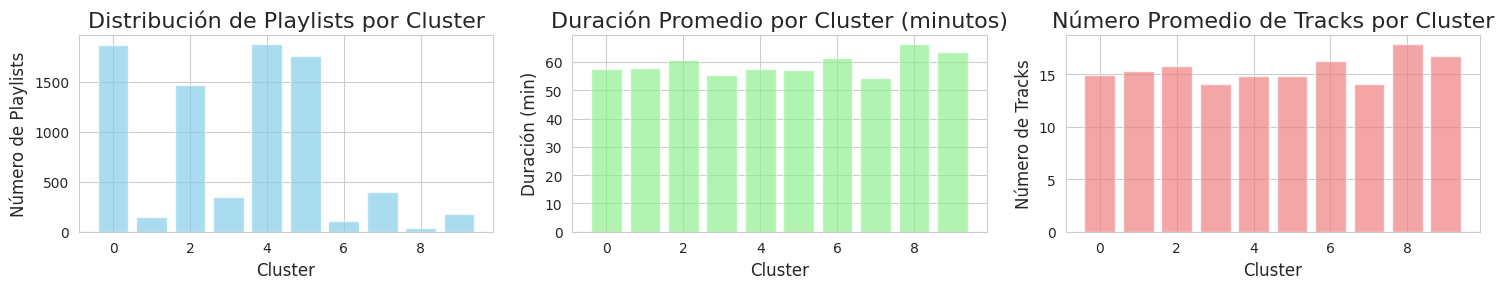

In [87]:
cluster_column = 'playlist_labels_kmeans'

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Distribución de clusters
cluster_counts = df_playlist[cluster_column].value_counts().sort_index()
# Corrected: Use single index for axes
axes[0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.7)
axes[0].set_title('Distribución de Playlists por Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Número de Playlists')

# Duración promedio por cluster
duration_by_cluster = df_playlist.groupby(cluster_column)['total_duration_ms'].mean() / 60000
# Corrected: Use single index for axes
axes[1].bar(duration_by_cluster.index, duration_by_cluster.values, color='lightgreen', alpha=0.7)
axes[1].set_title('Duración Promedio por Cluster (minutos)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Duración (min)')

# Número de tracks promedio por cluster
tracks_by_cluster = df_playlist.groupby(cluster_column)['n_tracks'].mean()
# Corrected: Use single index for axes
axes[2].bar(tracks_by_cluster.index, tracks_by_cluster.values, color='lightcoral', alpha=0.7)
axes[2].set_title('Número Promedio de Tracks por Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Número de Tracks')


plt.tight_layout()
plt.show()

In [91]:
# columnas que realmente quieres describir
core = ['avg_bpm','avg_energy','avg_danceability_ll','avg_loudness',"gender_female",
        'genre_dortmund_electronic','genre_dortmund_rock','genre_dortmund_pop',
        'genre_tzanetakis_cla','mood_party_party','mood_relaxed_relaxed',
        'timbre_bright','tonal_atonal_atonal',]

feat_df = df_playlist[core + ['playlist_labels_kmeans']]

# 1) centroides
centroids = feat_df.groupby('playlist_labels_kmeans').mean()

# 2) media y std global
global_mean = feat_df[core].mean()
global_std  = feat_df[core].std(ddof=0)

# 3) z‑scores del centroide ─ valores >0 ⇒ sobre el promedio
zcent = (centroids - global_mean) / global_std

# 4) quedarnos con top ±5 variables más “extremas” por cluster
summary = {}
for c, row in zcent.iterrows():
    top_pos = row.sort_values(ascending=False).head(5)
    top_neg = row.sort_values().head(5)
    summary[c] = pd.concat([top_pos, top_neg])

summary_df = (pd.concat(summary, axis=1)
                .rename_axis('feature')
                .T.reset_index()
                .rename(columns={'level_0':'cluster'}))



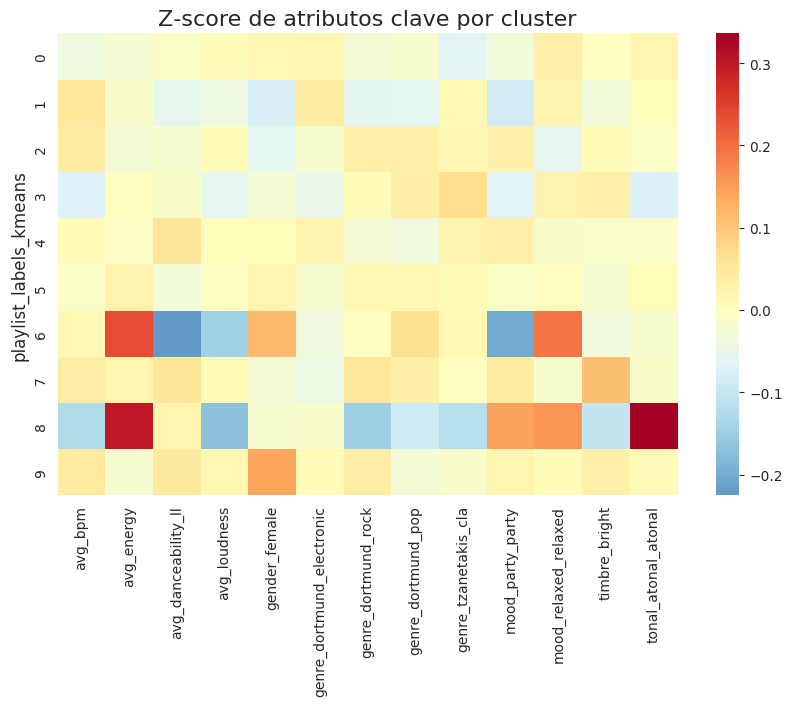

In [92]:
import seaborn as sns, matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(zcent[core], cmap='RdYlBu_r', center=0, annot=False)
plt.title("Z‑score de atributos clave por cluster")
plt.show()

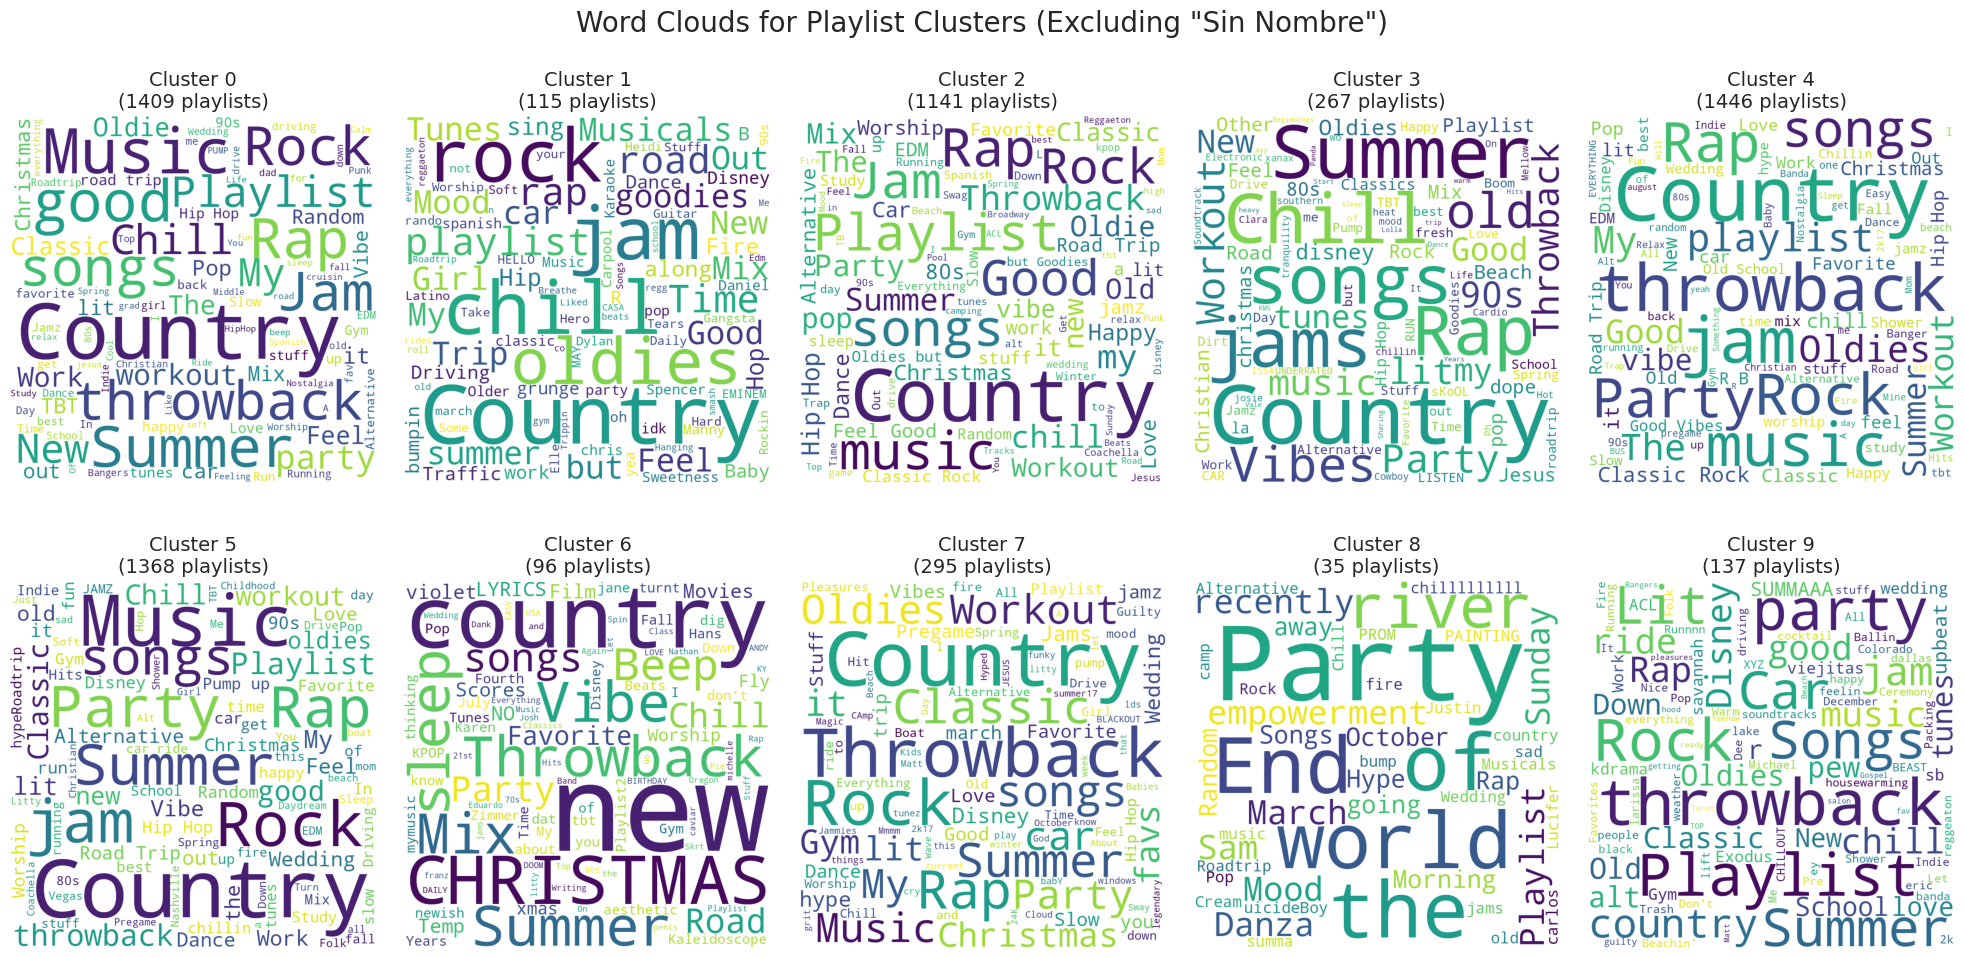

=== ESTADÍSTICAS DE FILTRADO ===
Total playlists originales: 8192
Playlists con 'sin nombre': 1883
Playlists después del filtro: 6309
Porcentaje filtrado: 23.0%

=== PLAYLISTS POR CLUSTER (DESPUÉS DEL FILTRO) ===
Cluster 0: 1409 playlists (era 1863)
Cluster 1: 115 playlists (era 152)
Cluster 2: 1141 playlists (era 1467)
Cluster 3: 267 playlists (era 352)
Cluster 4: 1446 playlists (era 1874)
Cluster 5: 1368 playlists (era 1756)
Cluster 6: 96 playlists (era 111)
Cluster 7: 295 playlists (era 395)
Cluster 8: 35 playlists (era 42)
Cluster 9: 137 playlists (era 180)


In [90]:
import math
from wordcloud import WordCloud

# Filter out playlists with "sin nombre" (case insensitive)
df_filtered = df_playlist[~df_playlist['name'].str.lower().str.contains('sin nombre', na=False)]

# Join all names for each cluster (excluding "sin nombre")
all_names = df_filtered.groupby('playlist_labels_kmeans')['name'].apply(lambda x: ' '.join(x))

# Determine the number of clusters
num_clusters = len(all_names)

# Determine the number of rows and columns for the plot
ncols = 5
nrows = math.ceil(num_clusters / ncols)

# Create the figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5)) # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate and plot word clouds for each cluster in the subplots
for i, (cluster_label, names) in enumerate(all_names.items()):
    # Check if there are any names after filtering
    if names.strip():  # Only create wordcloud if there are actual names
        wordcloud = WordCloud(width = 800, height = 800,
                              background_color ='white',
                              stopwords = set(), # Add stopwords if needed
                              min_font_size = 10,
                              max_words = 100,  # Limit number of words for better readability
                              relative_scaling = 0.5,  # Better word scaling
                              random_state = 42).generate(names)  # For reproducible results

        # plot the WordCloud image on the correct subplot
        axes[i].imshow(wordcloud)
        axes[i].axis("off")

        # Get count of playlists in this cluster (after filtering)
        cluster_count = len(df_filtered[df_filtered['playlist_labels_kmeans'] == cluster_label])
        original_count = len(df_playlist[df_playlist['playlist_labels_kmeans'] == cluster_label])

        axes[i].set_title(f'Cluster {cluster_label}\n({cluster_count} playlists)', fontsize=14)
    else:
        # If no names after filtering, show a message
        axes[i].text(0.5, 0.5, f'Cluster {cluster_label}\nNo named playlists',
                    ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
        axes[i].axis("off")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0) # Adjust padding between subplots
plt.suptitle('Word Clouds for Playlist Clusters (Excluding "Sin Nombre")', fontsize=20, y=1.02) # Add a main title
plt.show()

# Optional: Print some statistics about the filtering
print("=== ESTADÍSTICAS DE FILTRADO ===")
print(f"Total playlists originales: {len(df_playlist)}")
print(f"Playlists con 'sin nombre': {len(df_playlist) - len(df_filtered)}")
print(f"Playlists después del filtro: {len(df_filtered)}")
print(f"Porcentaje filtrado: {((len(df_playlist) - len(df_filtered)) / len(df_playlist) * 100):.1f}%")

print("\n=== PLAYLISTS POR CLUSTER (DESPUÉS DEL FILTRO) ===")
for cluster in sorted(df_filtered['playlist_labels_kmeans'].unique()):
    original_count = len(df_playlist[df_playlist['playlist_labels_kmeans'] == cluster])
    filtered_count = len(df_filtered[df_filtered['playlist_labels_kmeans'] == cluster])
    print(f"Cluster {cluster}: {filtered_count} playlists (era {original_count})")

## ✅ Caracterización de los 10 clusters (sin la etiqueta “sin nombre”)

esto es lo que interpretamos de cada cluster

| # | Título | Descripción en 2 líneas (word‑cloud + métricas) |
|---|-----------------------|--------------------------------------------------|
| **0** | **Country‑Rock** | “Country”, “Music”, “Rock”, “Summer”, “Party”.  Atributos neutros en BPM/Energy y alto recuento de pistas ⇒ listas extensas de country‑rock veraniego para socializar. |
| **1** | **Chill Oldies** | Cloud dominado por “Oldies”, “Chill”, “Tunes”, “Trip”.  Playlists cortas y tempo suave: pop nostálgico para viajes tranquilos. |
| **2** | **Rap‑Country Mix** | Palabras “Rap”, “Pop”, “Throwback”, pero “country” sigue grande.  Mood_party ligeramente alto y loudness medio: mezcla crossover rap‑country para fiesta ligera. |
| **3** | **Summer Vibes** | “Summer”, “Chill”, “Vibes”, “Songs”, “Beach”.  BPM neutro, energy baja: selecciones playeras relajadas con toque rap/pop. |
| **4** | **Country Party** | “Country”, “Rap”, “Throwback”, “Jam”, “Party”.  Mood_party y energy sobre la media; listas muy largas ⇒ soundtrack para reuniones country‑pop animadas. |
| **5** | **Jam Mix** | Cloud genérico pero con “Music”, “Party”, “Rock”, “Indie”.  Métricas casi planas; acting como contenedor variado de hits actuales sin eje definido. |
| **6** | **New Country Xmas** | Palabras gigantes “country”, “new”, “CHRISTMAS”.  BPM bajo y timbre brillante: compilados recientes de country + canciones navideñas acústicas. |
| **7** | **Classic Workout** | “Oldies”, “Workout”, “Classic”, “Throwback”, “Rock”.  Energy media‑alta pero BPM moderado: rock clásico y country para rutinas de gimnasio sin EDM. |
| **8** | **Alt‑Party** | Solo 35 listas con clave “Party”, “empowerment”, “Alternative”.  Energy y loudness altos, fuerte variabilidad tonal: playlists cortas, alt‑pop motivacional. |
| **9** | **Car Rock** | “party”, “cars”, “Rock”, “Summer”, “Songs”.  BPM medio‑alto, loudness +0.1 z ⇒ sets rock/pop up‑tempo para manejar con amigos. |

también vemos que los clusters 0, 2, 4 y 5 son muchas playlist con pocas canciones dentro o canciones muy cortas que son difíciles de clasificar

# 4: Reglas de Asociación
Vamos a hacer reglas de asociación dentro de los clusters para definirlos

In [93]:
track_meta = (df_processed
              .drop_duplicates('track_id')
              .set_index('track_id')
              .loc[:, ['track_name', 'artist_name', 'bpm', "energy", "bpm"]]
              .to_dict('index'))
def enrich_rule(row):
    ant_id  = next(iter(row['antecedents']))
    cons_id = next(iter(row['consequents']))
    ant_meta  = track_meta.get(ant_id, {})
    cons_meta = track_meta.get(cons_id, {})
    return pd.Series({
        "A_id": ant_id,
        "A_name": ant_meta.get('track_name'),
        "A_artist": ant_meta.get('artist_name'),
        "A_bpm": ant_meta.get('bpm'),
        "A_energy": ant_meta.get('energy'),
        "A_bpm" : ant_meta.get('bpm'),
        "B_id": cons_id,
        "B_name": cons_meta.get('track_name'),
        "B_artist": cons_meta.get('artist_name'),
        "B_bpm": cons_meta.get('bpm'),
        "B_energy": cons_meta.get('energy'),
        "B_bpm" : cons_meta.get('bpm'),
        "support": row['support'],
        "confidence": row['confidence'],
        "lift": row['lift']
    })


/tmp/ipython-input-93-3782691971.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  .to_dict('index'))


In [97]:
# 0) merge para que cada track sepa a qué cluster pertenece su playlist
tracks_w_cluster = (
    df_processed
      .merge(df_playlist[['pid', 'playlist_labels_kmeans']], on='pid', how='inner')
)

# 1) función auxiliar ─────────
def rules_for_cluster(df_cluster,
                      min_playlists=5,
                      min_support=0.0005,
                      min_lift=1.2,
                      top_n=25):

    n_play = df_cluster['pid'].nunique()
    abs_sup = max(min_playlists, int(min_support * n_play))
    rel_sup = abs_sup / n_play

    basket = (df_cluster.assign(val=True)
              .pivot_table(index='pid', columns='track_id',
                           values='val', aggfunc='max', fill_value=False)
              .astype(bool))

    # Mantén solo ítems que superan el soporte absoluto
    item_sup = basket.sum()
    basket   = basket.loc[:, item_sup >= abs_sup]
    if basket.shape[1] < 2:       # no hay pares posibles
        return pd.DataFrame()

    itemsets = fpgrowth(basket, min_support=rel_sup,
                        use_colnames=True, max_len=2)
    if itemsets.empty:
        return pd.DataFrame()

    rules = (association_rules(itemsets, metric='lift',
                               min_threshold=min_lift)
             .query('confidence < 0.95')        # filtra reglas “perfectas”
             .sort_values('lift', ascending=False)
             .head(top_n))
    return rules.reset_index(drop=True)

# 2) recorrer los 7 clusters ───────────────────
rules_by_cluster = {}

for c in sorted(tracks_w_cluster['playlist_labels_kmeans'].unique()):
    print(f"\n⏳ Procesando cluster {c} …")
    # Use the cluster labels directly from the merged DataFrame
    subset = tracks_w_cluster[ tracks_w_cluster['playlist_labels_kmeans'] == c ]

    # Dynamically adjust min_support based on the number of playlists in the cluster
    num_playlists_in_cluster = subset['pid'].nunique()
    # A possible heuristic: decrease min_support for smaller clusters
    # For example, if the average number of playlists is X, and a cluster has X/2 playlists,
    # you might halve the min_support for that cluster.
    # Let's start with a simple approach: min_support is inversely proportional to the number of playlists,
    # but with a lower bound to avoid finding too many trivial rules.
    base_min_support = 0.03 # Starting point
    min_support_c = max(0.0005, base_min_support * (num_playlists_in_cluster / tracks_w_cluster['pid'].nunique())) # Ensure a minimum support

    print(f"  Número de playlists en cluster {c}: {num_playlists_in_cluster}")
    print(f"  Usando min_support: {min_support_c:.4f}")


    rules_c = rules_for_cluster(subset,
                                min_support=min_support_c,  # adjusted min_support
                                min_lift=1.3,
                                top_n=30)
    rules_readable = rules_c.apply(enrich_rule, axis=1)
    rules_by_cluster[c] = rules_c

    print(f"✓ Cluster {c}: {len(rules_c)} reglas guardadas.")




⏳ Procesando cluster 0 …
  Número de playlists en cluster 0: 1863
  Usando min_support: 0.0068
✓ Cluster 0: 6 reglas guardadas.

⏳ Procesando cluster 1 …
  Número de playlists en cluster 1: 152
  Usando min_support: 0.0006
✓ Cluster 1: 0 reglas guardadas.

⏳ Procesando cluster 2 …
  Número de playlists en cluster 2: 1467
  Usando min_support: 0.0054
✓ Cluster 2: 30 reglas guardadas.

⏳ Procesando cluster 3 …
  Número de playlists en cluster 3: 352
  Usando min_support: 0.0013
✓ Cluster 3: 4 reglas guardadas.

⏳ Procesando cluster 4 …
  Número de playlists en cluster 4: 1874
  Usando min_support: 0.0069
✓ Cluster 4: 20 reglas guardadas.

⏳ Procesando cluster 5 …
  Número de playlists en cluster 5: 1756
  Usando min_support: 0.0064
✓ Cluster 5: 30 reglas guardadas.

⏳ Procesando cluster 6 …
  Número de playlists en cluster 6: 111
  Usando min_support: 0.0005
✓ Cluster 6: 0 reglas guardadas.

⏳ Procesando cluster 7 …
  Número de playlists en cluster 7: 395
  Usando min_support: 0.0014
✓ 

In [100]:
# --- 0) diccionario de metadatos básicos -----------------------
meta_cols = ['track_name', 'artist_name', 'bpm']
track_meta = (df_processed
              .drop_duplicates('track_id')
              .set_index('track_id')[meta_cols]
              .to_dict('index'))

def stringify(tid_set):
    """Convierte {id} o {id1,id2} → 'Name1 • Name2'."""
    names = [track_meta[tid]['track_name']
             if tid in track_meta else tid
             for tid in tid_set]
    return " • ".join(names)

def enrich_rules(rules_df):
    """Añade columnas legibles aún si hay ≥1 ids en antecedente/consecuente."""
    rules_df = rules_df.copy()
    rules_df['A_ids']  = rules_df['antecedents'].apply(list)
    rules_df['B_ids']  = rules_df['consequents'].apply(list)

    # nombres y artistas concatenados
    rules_df['A_names'] = rules_df['A_ids'].apply(lambda lst: " / ".join(
        [track_meta[i]['track_name']  if i in track_meta else i for i in lst]))
    rules_df['B_names'] = rules_df['B_ids'].apply(lambda lst: " / ".join(
        [track_meta[i]['track_name']  if i in track_meta else i for i in lst]))
    rules_df['A_artists'] = rules_df['A_ids'].apply(lambda lst: " / ".join(
        [track_meta[i]['artist_name'] if i in track_meta else "?" for i in lst]))
    rules_df['B_artists'] = rules_df['B_ids'].apply(lambda lst: " / ".join(
        [track_meta[i]['artist_name'] if i in track_meta else "?" for i in lst]))

    # ejemplo de atributo numérico medio (BPM) para antecedente
    rules_df['A_bpm_avg'] = rules_df['A_ids'].apply(
        lambda lst: np.mean([track_meta[i]['bpm'] for i in lst if i in track_meta]))

    return (rules_df
            .loc[:, ['A_names','A_artists','B_names','B_artists',
                     'support','confidence','lift']])

# Ejemplo para el cluster 2
for i in range (0, OPTIMAL_K):
    print(f"Cluster {i}:")
    if i in rules_by_cluster and len(rules_by_cluster[i])>0:
      readable_c2 = enrich_rules(rules_by_cluster[i])
      display(readable_c2)
    else:
      print(f"No hay reglas para el cluster {i}.")



Cluster 0:


,A_names,A_artists,B_names,B_artists,support,confidence,lift
0,Drunk On You,Luke Bryan,That's My Kind Of Night,Luke Bryan,0.006441,0.631579,47.065263
1,That's My Kind Of Night,Luke Bryan,Drunk On You,Luke Bryan,0.006441,0.480000,47.065263
2,Play It Again,Luke Bryan,That's My Kind Of Night,Luke Bryan,0.007515,0.538462,40.126154
3,That's My Kind Of Night,Luke Bryan,Play It Again,Luke Bryan,0.007515,0.560000,40.126154
4,Hotel California - Remastered,Eagles,More Than a Feeling,Boston,0.006978,0.433333,32.292000
5,More Than a Feeling,Boston,Hotel California - Remastered,Eagles,0.006978,0.520000,32.292000


Cluster 1:
No hay reglas para el cluster 1.
Cluster 2:


,A_names,A_artists,B_names,B_artists,support,confidence,lift
0,Whatever She's Got,David Nail,Ready Set Roll,Chase Rice,0.006135,0.600000,73.350000
1,Ready Set Roll,Chase Rice,Whatever She's Got,David Nail,0.006135,0.750000,73.350000
2,So Sick,Ne-Yo,Mad,Ne-Yo,0.005453,0.444444,72.444444
3,Mad,Ne-Yo,So Sick,Ne-Yo,0.005453,0.888889,72.444444
4,Loving You Easy,Zac Brown Band,Homegrown,Zac Brown Band,0.005453,0.571429,64.483516
5,Homegrown,Zac Brown Band,Loving You Easy,Zac Brown Band,0.005453,0.615385,64.483516
6,Yeah,Joe Nichols,Whatever She's Got,David Nail,0.006135,0.600000,58.680000
7,Whatever She's Got,David Nail,Yeah,Joe Nichols,0.006135,0.600000,58.680000
8,Chillin' It,Cole Swindell,Yeah,Joe Nichols,0.006817,0.588235,57.529412
9,Chillin' It,Cole Swindell,Whatever She's Got,David Nail,0.006817,0.588235,57.529412


Cluster 3:


,A_names,A_artists,B_names,B_artists,support,confidence,lift
0,"Sugar, We're Goin Down",Fall Out Boy,Dirty Little Secret,The All-American Rejects,0.014205,0.714286,41.904762
1,Dirty Little Secret,The All-American Rejects,"Sugar, We're Goin Down",Fall Out Boy,0.014205,0.833333,41.904762
2,Low Life,Future,2 Phones,Kevin Gates,0.014205,0.454545,17.777778
3,2 Phones,Kevin Gates,Low Life,Future,0.014205,0.555556,17.777778


Cluster 4:


,A_names,A_artists,B_names,B_artists,support,confidence,lift
0,Chicken Fried,Zac Brown Band,Homegrown,Zac Brown Band,0.006403,0.461538,48.051282
1,Homegrown,Zac Brown Band,Chicken Fried,Zac Brown Band,0.006403,0.666667,48.051282
2,You Was Right,Lil Uzi Vert,Money Longer,Lil Uzi Vert,0.009072,0.653846,45.381766
3,Money Longer,Lil Uzi Vert,You Was Right,Lil Uzi Vert,0.009072,0.629630,45.381766
4,Take Your Time,Sam Hunt,Leave The Night On,Sam Hunt,0.006403,0.571429,44.619048
5,Leave The Night On,Sam Hunt,Take Your Time,Sam Hunt,0.006403,0.500000,44.619048
6,Chicken Fried,Zac Brown Band,Knee Deep (feat. Jimmy Buffett),Zac Brown Band,0.007471,0.538462,40.363077
7,Knee Deep (feat. Jimmy Buffett),Zac Brown Band,Chicken Fried,Zac Brown Band,0.007471,0.560000,40.363077
8,Play It Again,Luke Bryan,Chicken Fried,Zac Brown Band,0.007471,0.500000,36.038462
9,Chicken Fried,Zac Brown Band,Play It Again,Luke Bryan,0.007471,0.538462,36.038462


Cluster 5:


,A_names,A_artists,B_names,B_artists,support,confidence,lift
0,Somewhere On A Beach,Dierks Bentley,T-Shirt,Thomas Rhett,0.007973,0.666667,55.746032
1,T-Shirt,Thomas Rhett,Somewhere On A Beach,Dierks Bentley,0.007973,0.666667,55.746032
2,Play It Again,Luke Bryan,Round Here,Florida Georgia Line,0.006264,0.578947,53.506925
3,Round Here,Florida Georgia Line,Play It Again,Luke Bryan,0.006264,0.578947,53.506925
4,That's My Kind Of Night,Luke Bryan,Play It Again,Luke Bryan,0.006834,0.545455,50.411483
5,Play It Again,Luke Bryan,That's My Kind Of Night,Luke Bryan,0.006834,0.631579,50.411483
6,Round Here,Florida Georgia Line,That's My Kind Of Night,Luke Bryan,0.006264,0.578947,46.210526
7,That's My Kind Of Night,Luke Bryan,Round Here,Florida Georgia Line,0.006264,0.500000,46.210526
8,This Is How We Roll,Florida Georgia Line,Play It Again,Luke Bryan,0.006834,0.480000,44.362105
9,Play It Again,Luke Bryan,This Is How We Roll,Florida Georgia Line,0.006834,0.631579,44.362105


Cluster 6:
No hay reglas para el cluster 6.
Cluster 7:
No hay reglas para el cluster 7.
Cluster 8:
No hay reglas para el cluster 8.
Cluster 9:
No hay reglas para el cluster 9.


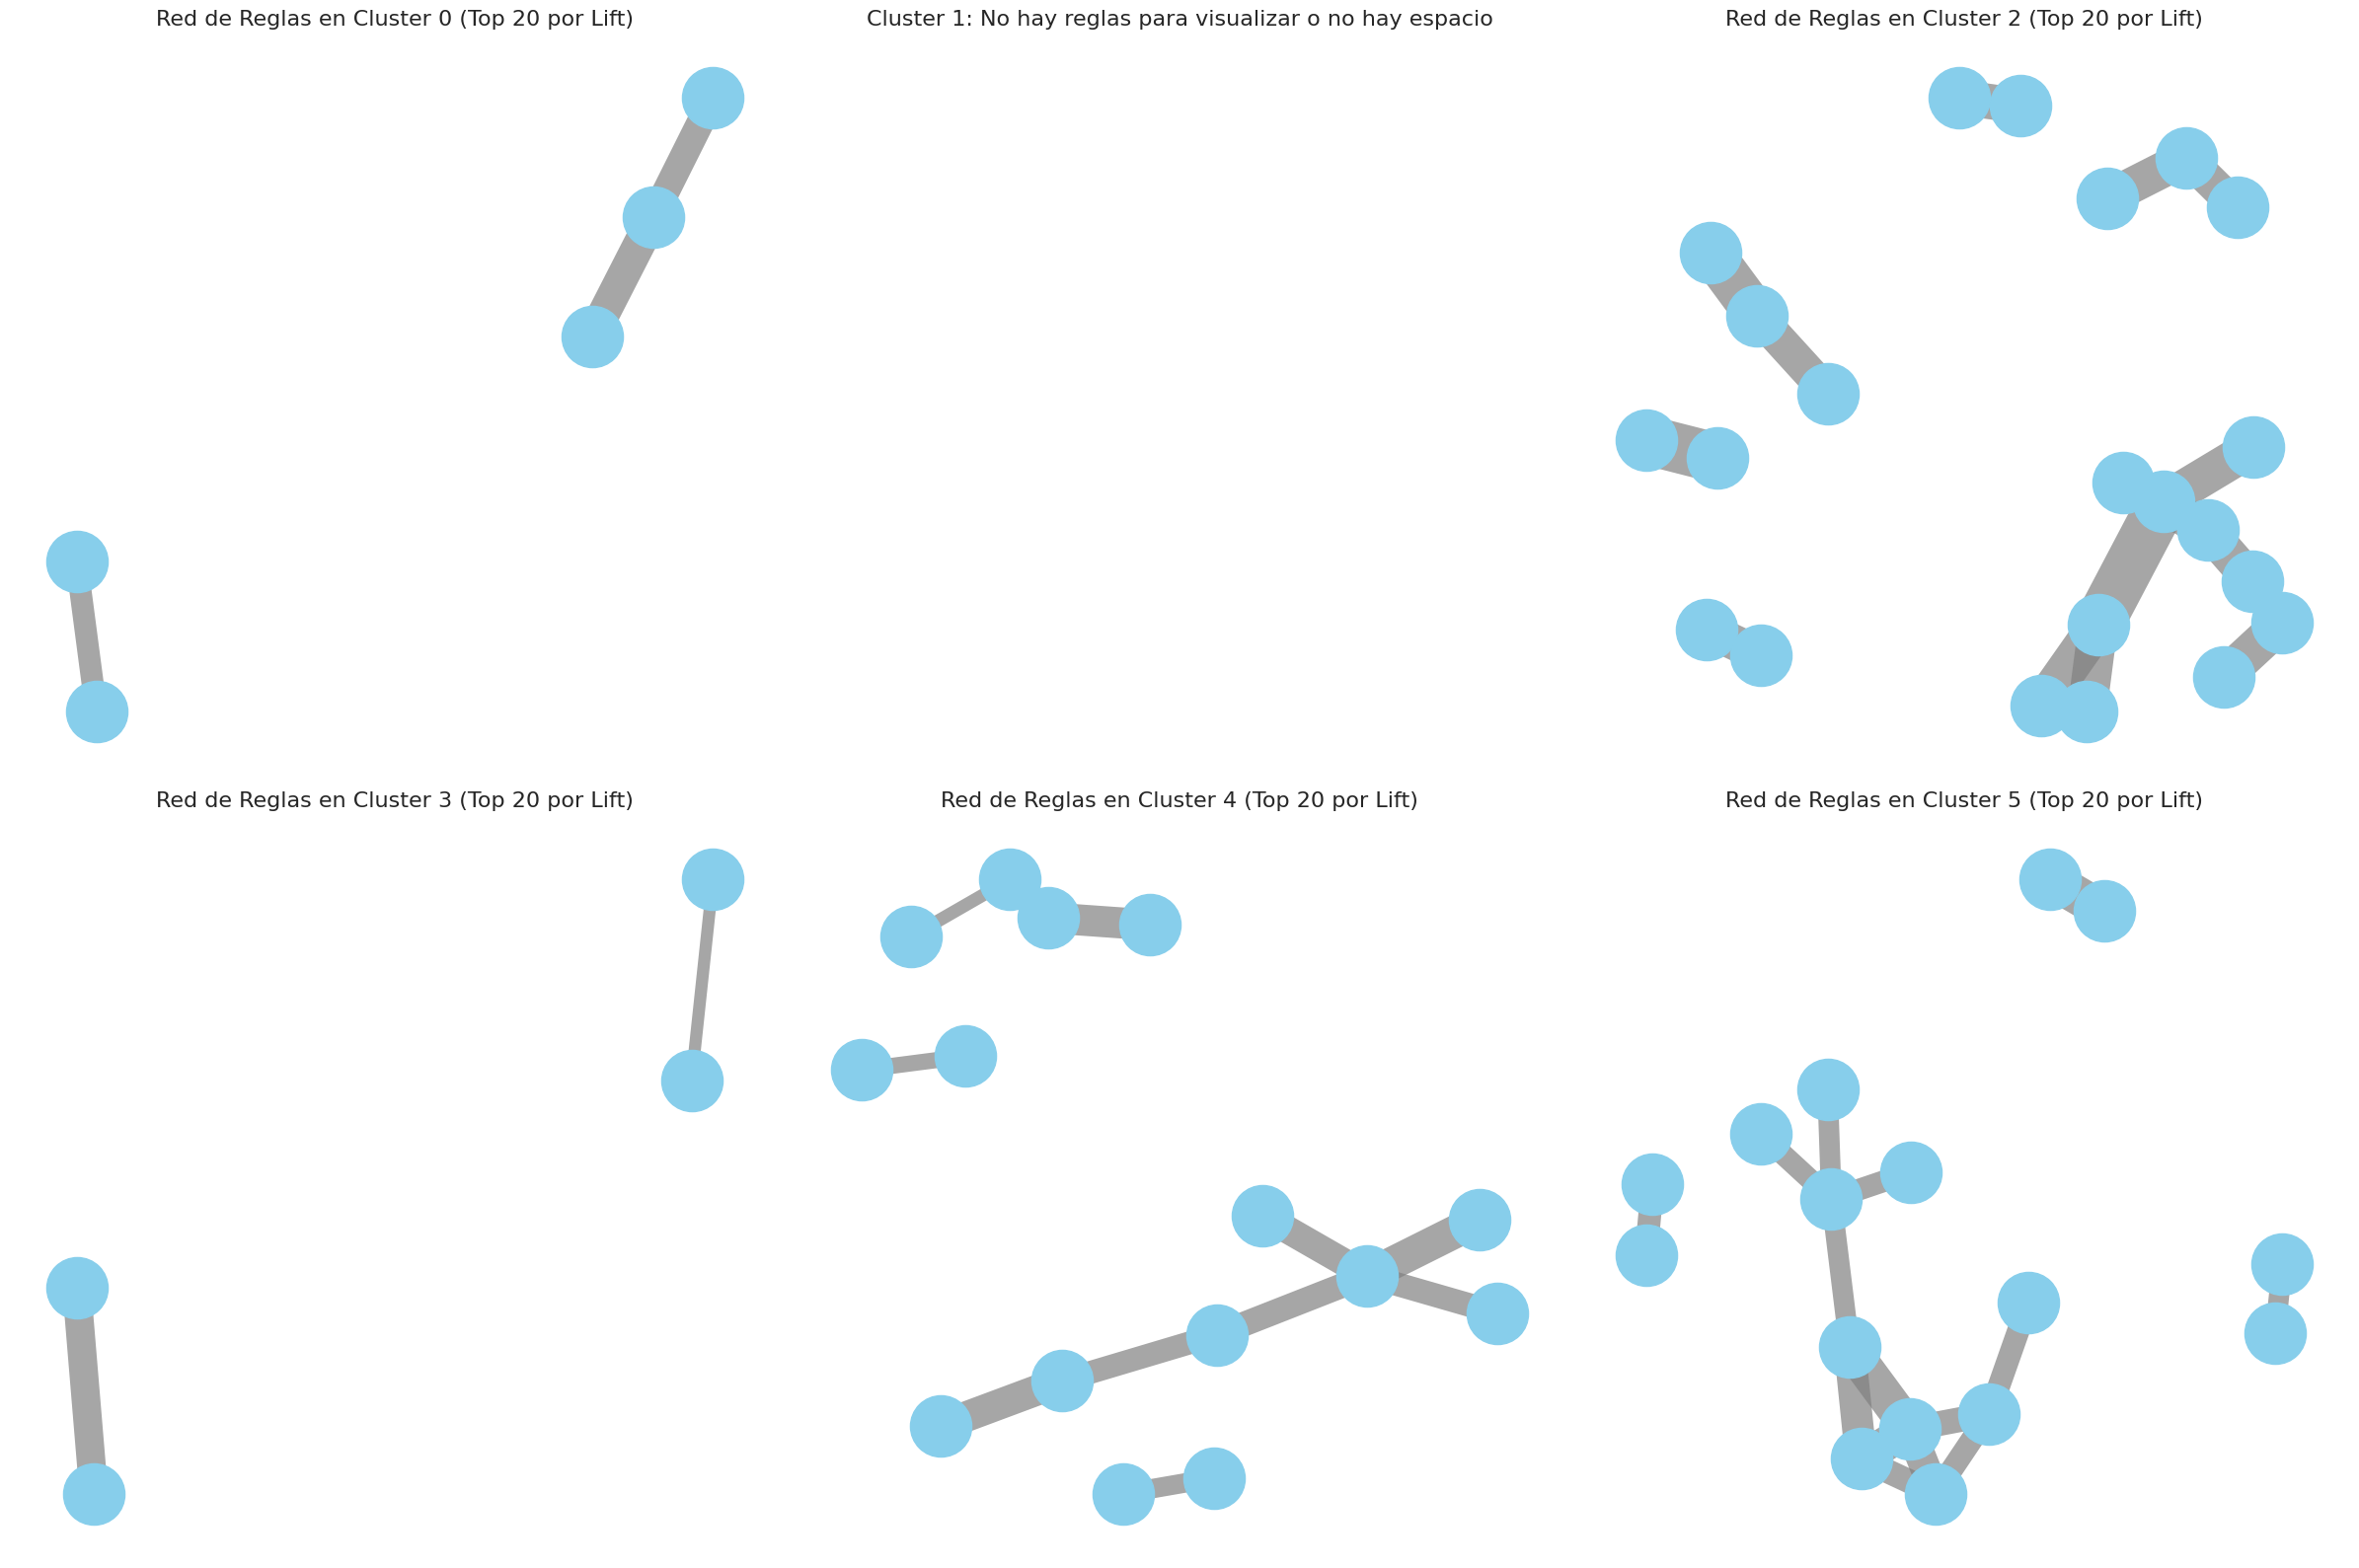

In [103]:
n_rows = 2
n_cols = 3

# Crear la figura y los ejes para los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 8)) # Ajusta el tamaño de la figura

# Aplanar la matriz de ejes para poder iterar fácilmente
axes = axes.flatten()

# CORRECTION: Iterate up to the total number of subplots created
for i in range(n_rows * n_cols):
    # Seleccionar el eje actual
    ax = axes[i]

    # NOTE: The original loop went up to OPTIMAL_K, but only 6 subplots are created.
    # We will only attempt to plot for the first 6 clusters (0-5) in this visualization.
    # If you need to visualize all 10 clusters, you would need to increase n_rows or n_cols.
    if i < OPTIMAL_K and i in rules_by_cluster and not rules_by_cluster[i].empty:
        G = nx.from_pandas_edgelist(rules_by_cluster[i],
                                  source='antecedents',
                                  target='consequents',
                                  edge_attr=['lift', 'confidence'])
        # Posiciones de los nodos
        pos = nx.spring_layout(G, k=0.5, iterations=50)
        # Dibujar nodos y etiquetas en el eje actual
        nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', ax=ax)
        # Dibujar aristas con grosor basado en el lift en el eje actual
        edge_width = [d['lift'] * 0.5 for (u, v, d) in G.edges(data=True)]
        nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.7, ax=ax)
        ax.set_title(f'Red de Reglas en Cluster {i} (Top 20 por Lift)')
        ax.axis('off')
    else:
        # Handle cases where there are no rules or the cluster index is beyond the subplot limit
        ax.set_title(f'Cluster {i}: No hay reglas para visualizar o no hay espacio')
        ax.axis('off')


# Ocultar los subplots restantes if any were skipped because of no rules
# This part is still necessary if some clusters within the 0-5 range had no rules
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])


plt.tight_layout() # Ajustar automáticamente los subplots para que no se solapen
plt.show()

In [108]:
from pathlib import Path

# --- Crear un directorio para los datos procesados ---
output_dir = Path("data/processed_for_prediction")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio de salida creado en: {output_dir}")


# --- Guardar los DataFrames esenciales ---

# 1. El Dataframe de playlist con los clusters demarcados

df_playlist.to_parquet(output_dir / "df_playlist_with_clusters.parquet", index=False)
print(f"df_playlist guardado en '{output_dir / 'df_playlist_with_clusters.parquet'}'")

Directorio de salida creado en: data/processed_for_prediction
df_playlist guardado en 'data/processed_for_prediction/df_playlist_with_clusters.parquet'


## 4.1 ✈ código de la versión anterior: Aplicar Algoritmos (Apriori y FP-Growth)
Ambos algoritmos buscan conjuntos de ítems (canciones) frecuentes. La diferencia principal es su rendimiento; FP-Growth suele ser más rápido.

El hiperparámetro clave aquí es min_support (soporte mínimo). Define la frecuencia mínima que debe tener un conjunto de canciones para ser considerado "frecuente". Un valor bajo encontrará más reglas pero tardará más. Empecemos con 0.005 (presente en al menos el 0.5% de las playlists)

In [ ]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth
import gc
import psutil
import os

def get_memory_usage():
    """Obtiene el uso actual de memoria del proceso"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # MB

def optimize_dataframe_memory(df):
    """Optimiza el uso de memoria del DataFrame"""
    print(f"Memoria inicial: {get_memory_usage():.2f} MB")

    # Convertir a sparse boolean con menor densidad
    s_bool = pd.SparseDtype("bool", fill_value=False)
    df_sparse = df.astype(s_bool)

    # Forzar garbage collection
    gc.collect()

    print(f"Memoria después de conversión sparse: {get_memory_usage():.2f} MB")
    return df_sparse

def filter_infrequent_items(df, min_support_items=0.001):
    """Elimina items que aparecen muy poco frecuentemente"""
    print("Filtrando items poco frecuentes...")

    # Calcular soporte de cada item individual
    item_support = df.sum() / len(df)

    # Mantener solo items que superen el umbral mínimo
    frequent_items = item_support[item_support >= min_support_items].index

    print(f"Items originales: {len(df.columns)}")
    print(f"Items frecuentes mantenidos: {len(frequent_items)}")

    return df[frequent_items]

def sample_transactions(df, sample_size=0.8, random_state=42):
    """Reduce el tamaño del dataset mediante muestreo"""
    if sample_size < 1.0:
        print(f"Aplicando muestreo: {sample_size*100}% de las transacciones")
        df_sampled = df.sample(frac=sample_size, random_state=random_state)
        print(f"Transacciones: {len(df)} -> {len(df_sampled)}")
        return df_sampled
    return df

def run_apriori_optimized(df_transactions, min_support=0.005, max_len=3):
    """
    Ejecuta Apriori con optimizaciones de memoria

    Parameters:
    - df_transactions: DataFrame con transacciones
    - min_support: Soporte mínimo
    - max_len: Longitud máxima de itemsets (limita memoria)
    """

    print("=== OPTIMIZACIÓN DE MEMORIA ===")

    # 1. Filtrar items poco frecuentes
    df_filtered = filter_infrequent_items(df_transactions, min_support_items=min_support/2)
    gc.collect()

    # 2. Aplicar muestreo si es necesario (ajusta según tu RAM)
    df_sampled = sample_transactions(df_filtered, sample_size=0.7)  # Usa el 70%
    gc.collect()

    # 3. Optimizar tipos de datos
    df_optimized = optimize_dataframe_memory(df_sampled)

    print("\n=== EJECUTANDO APRIORI ===")
    print(f"Dataset final: {df_optimized.shape}")
    print(f"Memoria antes de Apriori: {get_memory_usage():.2f} MB")

    try:
        # Usar low_memory=True y max_len para controlar memoria
        frequent_itemsets = apriori(
            df_optimized,
            min_support=min_support,
            use_colnames=True,
            verbose=1,
            low_memory=True,        # IMPORTANTE: activa modo de baja memoria
            max_len=max_len         # Limita la longitud máxima de itemsets
        )

        print(f"\n✅ Apriori completado exitosamente!")
        print(f"Conjuntos frecuentes encontrados: {len(frequent_itemsets)}")
        print(f"Memoria final: {get_memory_usage():.2f} MB")

        return frequent_itemsets

    except MemoryError:
        print("❌ Error de memoria con Apriori. Intentando con FP-Growth...")

def run_fpgrowth_alternative(df_optimized, min_support, max_len):
    """Alternativa usando FP-Growth con optimizaciones extremas"""
    print("Intentando FP-Growth con optimizaciones extremas...")

    # Reducir aún más el dataset
    print("Aplicando reducción extrema del dataset...")
    df_ultra_small = df_optimized.sample(frac=0.3, random_state=42)  # Solo 30%

    # Filtrar items aún más agresivamente
    item_support = df_ultra_small.sum() / len(df_ultra_small)
    very_frequent_items = item_support[item_support >= min_support * 2].index  # 2x más restrictivo
    df_ultra_filtered = df_ultra_small[very_frequent_items]

    print(f"Dataset ultra-reducido: {df_ultra_filtered.shape}")
    print(f"Memoria antes de FP-Growth: {get_memory_usage():.2f} MB")

    try:
        frequent_itemsets = fpgrowth(
            df_ultra_filtered,
            min_support=min_support * 1.5,  # Aumentar soporte mínimo
            use_colnames=True,
            verbose=1,
            max_len=min(max_len, 2)  # Máximo 2 items
        )

        print(f"✅ FP-Growth completado con dataset reducido!")
        print(f"Conjuntos frecuentes encontrados: {len(frequent_itemsets)}")
        return frequent_itemsets

    except Exception as e:
        print(f"❌ FP-Growth también falló: {e}")
        return None


In [ ]:
# --- 4.1 Búsqueda de Ítems Frecuentes ---

# Hiperparámetro a ajustar
MIN_SUPPORT = 0.005

# --- Algoritmo 1: Apriori ---
print("Ejecutando Apriori...")

frequent_itemsets_apriori = run_apriori_optimized(
    df_transactions,
    min_support=0.005,
    max_len=3
)
print(f"Apriori encontró {len(frequent_itemsets_apriori)} ")

Ejecutando Apriori...
=== OPTIMIZACIÓN DE MEMORIA ===
Filtrando items poco frecuentes...
Items originales: 66243
Items frecuentes mantenidos: 2439
Aplicando muestreo: 70.0% de las transacciones
Transacciones: 9000 -> 6300
Memoria inicial: 2385.91 MB
Memoria después de conversión sparse: 2397.70 MB

=== EJECUTANDO APRIORI ===
Dataset final: (6300, 2439)
Memoria antes de Apriori: 2397.70 MB
Processing 219 combinations | Sampling itemset size 2

✅ Apriori completado exitosamente!
Conjuntos frecuentes encontrados: 1057
Memoria final: 2401.64 MB
Apriori encontró 1057 


In [ ]:
# # --- 4.1 Búsqueda de Ítems Frecuentes ---

# # Hiperparámetro a ajustar
# MIN_SUPPORT = 0.005

# # --- Algoritmo 1: Apriori ---
# print("Ejecutando Apriori...")

# frequent_itemsets_apriori = apriori(df_sparse,
#                         min_support=MIN_SUPPORT,      # tu umbral
#                         use_colnames=True,
#                         verbose=1,             # muestra el progreso
#                         low_memory=False)
# print(f"Apriori encontró {len(frequent_itemsets_apriori)} conjuntos de ítems frecuentes.")

Modo ultra-ligero para casos extremos:

Muestreo súper agresivo (máximo 5000 transacciones)
Solo top 50 items más frecuentes
Máximo itemsets de tamaño 2
porque no me carga

In [ ]:

# 2) FP-Growth con restricciones
frequent_itemsets_fpgrowth =  run_fpgrowth_alternative(
                df_transactions,
                min_support=0.005,
                max_len=3)

# Mostramos los 10 más frecuentes encontrados por FP-Growth
print("\nTop 10 conjuntos de ítems más frecuentes:")
frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10)

Intentando FP-Growth con optimizaciones extremas...
Aplicando reducción extrema del dataset...
Dataset ultra-reducido: (2700, 219)
Memoria antes de FP-Growth: 2572.45 MB
219 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (62vpWI1CHwFy7tMIcSStl8)
0 itemset(s) from tree conditioned on items (27GmP9AWRs744SzKcpJsTZ)
0 itemset(s) from tree conditioned on items (439TlnnznSiBbQbgXiBqAd)
0 itemset(s) from tree conditioned on items (2FBUoWkIuQXwayw2RNo5l6)
0 itemset(s) from tree conditioned on items (25khomWgBVamSdKw7hzm3l)
0 itemset(s) from tree conditioned on items (2d8JP84HNLKhmd6IYOoupQ)
0 itemset(s) from tree conditioned on items (4w7yrP4RAeeyhfG9nJqQvS)
0 itemset(s) from tree conditioned on items (7wwifjNAb172PtDpKK3CoR)
0 itemset(s) from tree conditioned on items (0uMUvbkTdjBNZ5UuHZ5PIj)
0 itemset(s) from tree conditioned on items (5nN8BwAQDJDguq7Dpd3JQQ)
0 itemset(s) from tree conditioned on items (5lFDtgWsjRJu8fPOAyJIAK)
0 itemset(s) from tree

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


1 itemset(s) from tree conditioned on items (0VgkVdmE4gld66l8iyGjgx)
0 itemset(s) from tree conditioned on items (152lZdxL1OR0ZMW6KquMif)
0 itemset(s) from tree conditioned on items (343YBumqHu19cGoGARUTsd)
0 itemset(s) from tree conditioned on items (0KKkJNfGyhkQ5aFogxQAPU)
0 itemset(s) from tree conditioned on items (2ANLarE8yHVsLWW21nj79M)
0 itemset(s) from tree conditioned on items (1f5cbQtDrykjarZVrShaDI)
0 itemset(s) from tree conditioned on items (6WhzFzROw3aq3rPWjgYlxr)
0 itemset(s) from tree conditioned on items (7KOlJ92bu51cltsD9KU5I7)
0 itemset(s) from tree conditioned on items (19a3JfW8BQwqHWUMbcqSx8)
0 itemset(s) from tree conditioned on items (5CtI0qwDJkDQGwXD1H1cLb)
0 itemset(s) from tree conditioned on items (7hDc8b7IXETo14hHIHdnhd)
0 itemset(s) from tree conditioned on items (20dP2DaMHIAmwWAbp7peSr)
0 itemset(s) from tree conditioned on items (4Q3N4Ct4zCuIHuZ65E3BD4)
0 itemset(s) from tree conditioned on items (6mapJIPnQ23RTAevUoE0DL)
0 itemset(s) from tree conditioned

,support,itemsets
19,0.025556,(7yyRTcZmCiyzzJlNzGC9Ol)
84,0.024074,(1xznGGDReH1oQq0xzbwXa3)
0,0.022963,(62vpWI1CHwFy7tMIcSStl8)
20,0.022593,(7KXjTSCq5nL1LoYtL7XAwS)
12,0.022593,(1AhDOtG9vPSOmsWgNW0BEY)
69,0.022593,(5XJJdNPkwmbUwE79gv0NxK)
1,0.021852,(27GmP9AWRs744SzKcpJsTZ)
21,0.021111,(7BKLCZ1jbUBVqRi2FVlTVw)
134,0.021111,(2KpCpk6HjXXLb7nnXoXA5O)
184,0.021111,(5dNfHmqgr128gMY2tc5CeJ)


In [ ]:
frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(10)

,support,itemsets
982,0.026190,(7yyRTcZmCiyzzJlNzGC9Ol)
652,0.025397,(5XJJdNPkwmbUwE79gv0NxK)
666,0.025079,(5dNfHmqgr128gMY2tc5CeJ)
732,0.023810,(62vpWI1CHwFy7tMIcSStl8)
918,0.022698,(7KXjTSCq5nL1LoYtL7XAwS)
895,0.022381,(7BKLCZ1jbUBVqRi2FVlTVw)
263,0.022222,(27GmP9AWRs744SzKcpJsTZ)
101,0.022222,(0v9Wz8o0BT8DU38R4ddjeH)
235,0.021587,(1xznGGDReH1oQq0xzbwXa3)
513,0.020952,(4Km5HrUvYTaSUfiSGPJeQR)


In [ ]:
frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10)

,support,itemsets
19,0.025556,(7yyRTcZmCiyzzJlNzGC9Ol)
84,0.024074,(1xznGGDReH1oQq0xzbwXa3)
0,0.022963,(62vpWI1CHwFy7tMIcSStl8)
20,0.022593,(7KXjTSCq5nL1LoYtL7XAwS)
12,0.022593,(1AhDOtG9vPSOmsWgNW0BEY)
69,0.022593,(5XJJdNPkwmbUwE79gv0NxK)
1,0.021852,(27GmP9AWRs744SzKcpJsTZ)
21,0.021111,(7BKLCZ1jbUBVqRi2FVlTVw)
134,0.021111,(2KpCpk6HjXXLb7nnXoXA5O)
184,0.021111,(5dNfHmqgr128gMY2tc5CeJ)


In [ ]:
#codigo para mostrar en la terminal las caracterisiticas del RAM y CPU disponible
import psutil

# Mostrar características de la CPU
print("Características de la CPU:")
print(f"Núcleos: {psutil.cpu_count(logical=False)}")
print(f"Frecuencia: {psutil.cpu_freq().current} MHz")

# Mostrar características de la RAM
print("\nCaracterísticas de la RAM:")
print(f"Total: {psutil.virtual_memory().total / (1024 ** 3):.2f} GB")

Características de la CPU:
Núcleos: 1
Frecuencia: 2000.222 MHz

Características de la RAM:
Total: 12.67 GB


### 4.2 Generar y Analizar Reglas de Asociación
A partir de los conjuntos frecuentes, generamos las reglas. Nos interesan principalmente dos métricas:

Confianza (Confidence): La probabilidad de encontrar el item B si ya tienes el item A.
Lift: Mide cuánto más probable es encontrar B si tienes A, en comparación con la probabilidad de encontrar B por sí solo. Un lift > 1 indica una asociación positiva.

In [ ]:
from mlxtend.frequent_patterns import association_rules

# --- reglas completas ---
rules = association_rules(frequent_itemsets_fpgrowth,
                          metric="confidence", min_threshold=0.1)

# 1) Filtro inicial
sig = rules[(rules['lift'] > 1.5) & (rules['confidence'] > 0.2)].copy()

# 2) Clave canónica = antecedentes ∪ consecuentes (ordenado)
sig['pair_key'] = sig.apply(
    lambda r: frozenset(r['antecedents'] | r['consequents']),
    axis=1
)

# 3) Ordena por la métrica que quieras privilegiar
significant_rules = sig.sort_values('lift', ascending=False)   # o 'confidence'

# 4) Quita duplicados usando la clave
significant_rules = sig.drop_duplicates(subset='pair_key', keep='first').reset_index(drop=True)

print(f"Se generaron {len(rules)} reglas en total.")
print(f"Se encontraron {len(significant_rules)} reglas significativas sin duplicados.\n")

print("Top 5 reglas de asociación (sin repeticiones por espejo):")
display(significant_rules.head(5))


Se generaron 16 reglas en total.
Se encontraron 8 reglas significativas sin duplicados.

Top 5 reglas de asociación (sin repeticiones por espejo):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,pair_key
0,(7yyRTcZmCiyzzJlNzGC9Ol),(0v9Wz8o0BT8DU38R4ddjeH),0.025556,0.020370,0.009259,0.362319,17.786561,1.0,0.008739,1.536237,0.968529,0.252525,0.349059,0.408432,"(7yyRTcZmCiyzzJlNzGC9Ol, 0v9Wz8o0BT8DU38R4ddjeH)"
1,(7KXjTSCq5nL1LoYtL7XAwS),(0VgkVdmE4gld66l8iyGjgx),0.022593,0.017778,0.008889,0.393443,22.131148,1.0,0.008487,1.619339,0.976885,0.282353,0.382464,0.446721,"(7KXjTSCq5nL1LoYtL7XAwS, 0VgkVdmE4gld66l8iyGjgx)"
2,(5kjyiH6but1t2UDXq15aeS),(4dGJf1SER1T6ooX46vwzRB),0.010741,0.013333,0.008519,0.793103,59.482759,1.0,0.008375,4.768889,0.993863,0.547619,0.790308,0.715996,"(5kjyiH6but1t2UDXq15aeS, 4dGJf1SER1T6ooX46vwzRB)"
3,(7KXjTSCq5nL1LoYtL7XAwS),(6HZILIRieu8S0iqY8kIKhj),0.022593,0.014444,0.008148,0.360656,24.968474,1.0,0.007822,1.541510,0.982139,0.282051,0.351285,0.462379,"(7KXjTSCq5nL1LoYtL7XAwS, 6HZILIRieu8S0iqY8kIKhj)"
4,(7yyRTcZmCiyzzJlNzGC9Ol),(5uDASfU19gDxSjW8cnCaBp),0.025556,0.017037,0.008148,0.318841,18.714556,1.0,0.007713,1.443073,0.971390,0.236559,0.307035,0.398551,"(7yyRTcZmCiyzzJlNzGC9Ol, 5uDASfU19gDxSjW8cnCaBp)"


### 4.3 Entregables (CSV y Gráfico de Red)


Reglas guardadas en 'data/results/reglas_asociacion_significativas.csv'


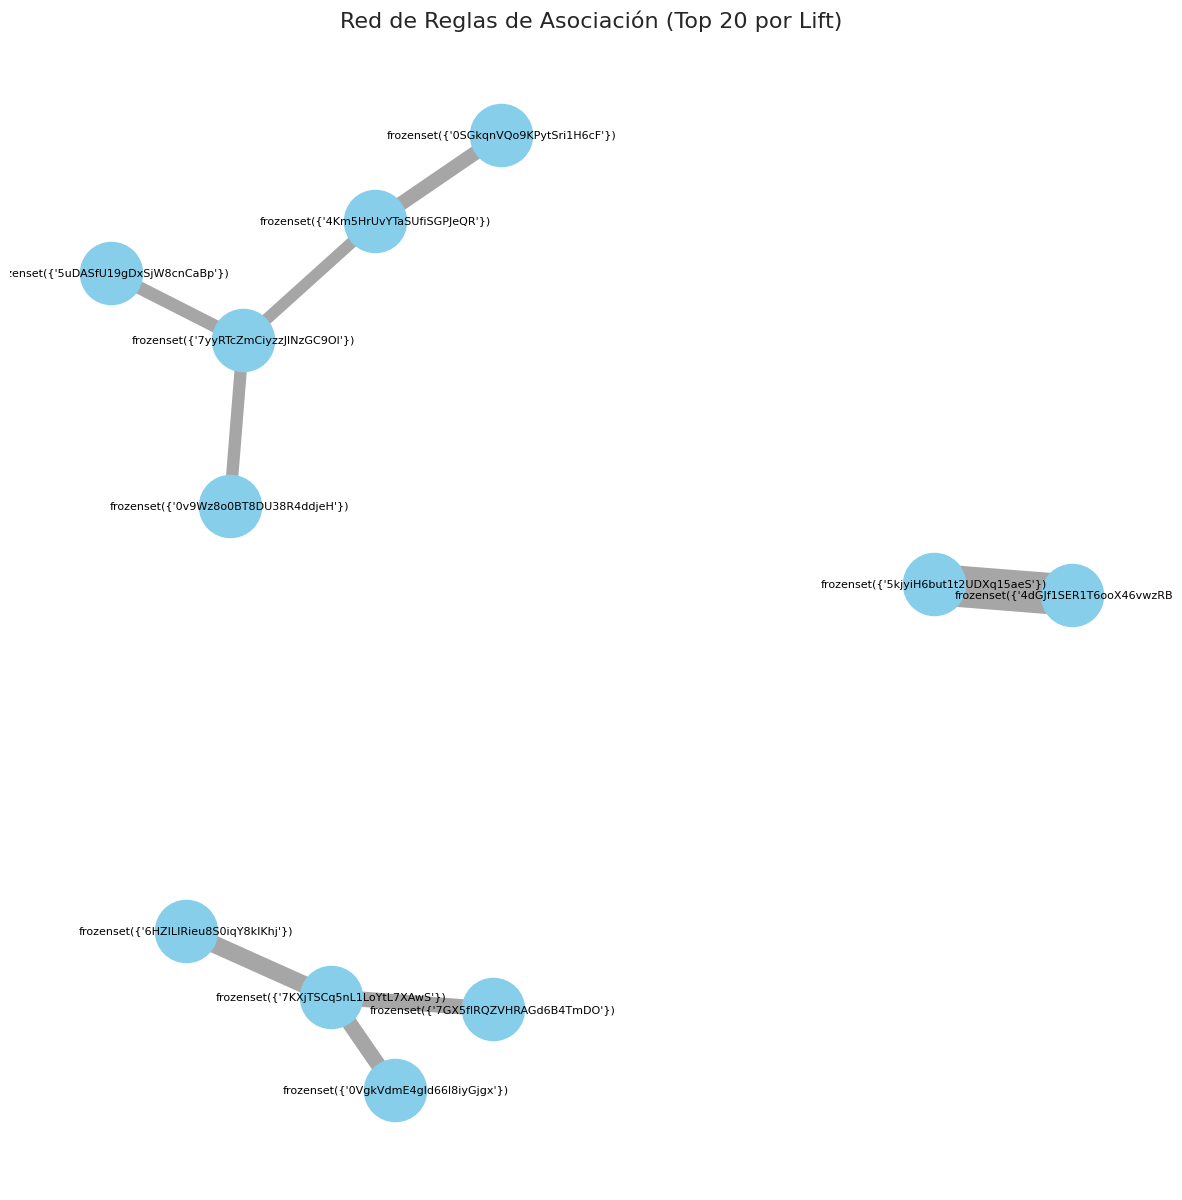

In [ ]:
# --- 4.3 Entregables ---

# 1. Guardar las reglas en un archivo CSV
rules_output_path = Path("data/results")
rules_output_path.mkdir(parents=True, exist_ok=True)
significant_rules.to_csv(rules_output_path / "reglas_asociacion_significativas.csv", index=False)
print(f"Reglas guardadas en '{rules_output_path / 'reglas_asociacion_significativas.csv'}'")


# 2. Visualización: Gráfico de Red de las 20 reglas principales
# (Puede ser lento si hay muchas reglas)
top_rules = significant_rules.head(20)

plt.figure(figsize=(15, 15))
G = nx.from_pandas_edgelist(top_rules,
                           source='antecedents',
                           target='consequents',
                           edge_attr=['lift', 'confidence'])

# Posiciones de los nodos
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Dibujar nodos y etiquetas
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8)

# Dibujar aristas con grosor basado en el lift
edge_width = [d['lift'] * 0.5 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.7)

plt.title('Red de Reglas de Asociación (Top 20 por Lift)')
plt.axis('off')
plt.show()


Clustering con K-Means completado usando k=5.
Ejecutando DBSCAN...
DBSCAN completado.
Ejecutando MiniBatchKMeans...
MiniBatchKMeans completado.

Calculando métricas de evaluación...
Evaluando K-Means...
Evaluando DBSCAN...
DBSCAN no encontró suficientes clusters para ser evaluado.
Evaluando MiniBatchKMeans...

--- Tabla Comparativa de Modelos de Clustering de Tracks ---


,Algoritmo,Silhouette Score (más alto es mejor),Davies-Bouldin Score (más bajo es mejor)
0,K-Means,0.393663,0.850035
1,DBSCAN,-1.000000,-1.000000
2,MiniBatchKMeans,0.377706,0.861170



Generando visualización de clusters (ejemplo con K-Means)...


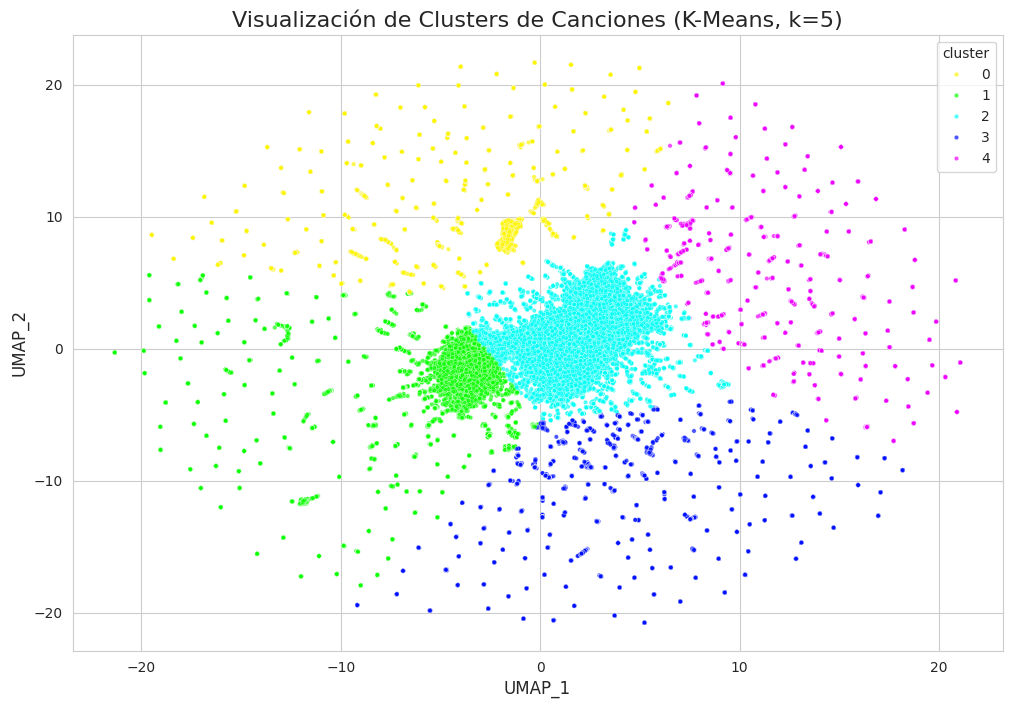

In [ ]:
UMAP_tracks = tracks_umap.copy()
UMAP_tracks_numeric = UMAP_tracks.select_dtypes(include=np.number)
# Basado en el gráfico, elegimos un valor para k (ej. k=8 donde la curva se aplana)
OPTIMAL_K = 5
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
# Usamos el DataFrame NUMÉRICO aquí también
track_labels_kmeans = kmeans.fit_predict(UMAP_tracks_numeric)

print(f"\nClustering con K-Means completado usando k={OPTIMAL_K}.")
# --- 5.A.2 Algoritmos 2 y 3: DBSCAN y MiniBatchKMeans (CORREGIDO Y OPTIMIZADO) ---

# --- DBSCAN ---
# DBSCAN puede ser lento en datasets grandes. Sus hiperparámetros son clave.
# Si esta parte también es muy lenta, considera ejecutarla sobre una muestra o ajustar 'eps'.
print("Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=2.5, min_samples=20, n_jobs=-1) # n_jobs=-1 usa todos los núcleos de tu CPU
track_labels_dbscan = dbscan.fit_predict(UMAP_tracks_numeric)
print("DBSCAN completado.")


# --- MiniBatchKMeans (Reemplazo eficiente para Agglomerative Clustering) ---
# Este algoritmo es mucho más rápido y consume muchísima menos memoria.
print("Ejecutando MiniBatchKMeans...")
mini_batch_kmeans = MiniBatchKMeans(
    n_clusters=OPTIMAL_K, # Usamos el mismo k que en KMeans
    random_state=42,
    batch_size=256, # Tamaño del lote, un hiperparámetro a ajustar
    n_init=10
)
track_labels_minibatch = mini_batch_kmeans.fit_predict(UMAP_tracks_numeric)
print("MiniBatchKMeans completado.")

# --- 5.A.3 Evaluación Comparativa y Visualización (MODIFICADO Y CORREGIDO) ---

print("\nCalculando métricas de evaluación...")

# --- K-Means ---
# CORREGIDO: Usamos X_tracks_numeric para el cálculo de los scores.
print("Evaluando K-Means...")
score_s_kmeans = silhouette_score(UMAP_tracks_numeric, track_labels_kmeans)
score_db_kmeans = davies_bouldin_score(UMAP_tracks_numeric, track_labels_kmeans)

# --- DBSCAN ---
# CORREGIDO: Usamos X_tracks_numeric y mantenemos la optimización de muestreo para el cálculo.
print("Evaluando DBSCAN...")
mask_dbscan = track_labels_dbscan != -1 # Filtro para excluir puntos de ruido (label -1)

# Nos aseguramos de que DBSCAN haya encontrado más de 1 clúster para poder evaluar
if len(set(track_labels_dbscan[mask_dbscan])) > 1:
    # Usamos una muestra para que el cálculo del score sea rápido en datasets grandes
    # Tomamos una muestra de hasta 20,000 puntos que no sean ruido
    sample_size = min(20000, np.sum(mask_dbscan))

    # --- FIX START ---
    # Reset the index of X_tracks_numeric to allow for integer indexing
    UMAP_tracks_numeric_reset = UMAP_tracks_numeric.reset_index(drop=True)
    # Use the index of the filtered data (mask_dbscan) to sample from the reset DataFrame
    sample_indices = np.random.choice(UMAP_tracks_numeric_reset[mask_dbscan].index, size=sample_size, replace=False)

    score_s_dbscan = silhouette_score(UMAP_tracks_numeric_reset.loc[sample_indices], track_labels_dbscan[sample_indices])
    score_db_dbscan = davies_bouldin_score(UMAP_tracks_numeric_reset.loc[sample_indices], track_labels_dbscan[sample_indices])
    # --- FIX END ---
else:
    # If DBSCAN no encontró clusters (o solo uno), asignamos un score inválido
    print("DBSCAN no encontró suficientes clusters para ser evaluado.")
    score_s_dbscan = -1
    score_db_dbscan = -1

# --- MiniBatchKMeans ---
# NUEVO: Reemplazamos la evaluación de Agglomerative por la de MiniBatchKMeans.
print("Evaluando MiniBatchKMeans...")
score_s_minibatch = silhouette_score(UMAP_tracks_numeric, track_labels_minibatch)
score_db_minibatch = davies_bouldin_score(UMAP_tracks_numeric, track_labels_minibatch)


# --- Crear tabla de resultados ---
# CORREGIDO: Actualizamos la lista de algoritmos y las variables de los scores.
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'MiniBatchKMeans'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_minibatch],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_minibatch]
})

print("\n--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
display(results)


# --- Visualización de Clusters ---
# Este bloque no necesita cambios, pero lo mantenemos por completitud.
# Muestra los resultados de K-Means como ejemplo.
# Nota: Para visualizar otros resultados, simplemente cambia 'track_labels_kmeans'
# por 'track_labels_minibatch' o 'track_labels_dbscan'.

print("\nGenerando visualización de clusters (ejemplo con K-Means)...")
viz_df = tracks_umap.copy()
viz_df['cluster'] = track_labels_kmeans

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='cluster',
    palette=sns.color_palette("hsv", n_colors=OPTIMAL_K),
    s=10, # Tamaño de los puntos
    alpha=0.7,
    legend='full'
)
plt.title(f'Visualización de Clusters de Canciones (K-Means, k={OPTIMAL_K})')
plt.show()
